In [1]:
# Import the essential libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Download historical data for the S&P 500 ETF (SPY)
print("Attempting to download data for SPY...")
df = yf.download('SPY', start='2010-01-01', end='2023-12-31')

# Display the first 5 rows to confirm it loaded
print("Data loaded successfully. Here are the first 5 rows:")
df.head()

Attempting to download data for SPY...


/var/folders/23/6jn5cmq120s0jn7h0jm0r36h0000gn/T/ipykernel_31576/2430475266.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('SPY', start='2010-01-01', end='2023-12-31')
[*********************100%***********************]  1 of 1 completed

Data loaded successfully. Here are the first 5 rows:


Price,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY
Date,,,,,
2010-01-04,85.515610,85.560882,84.142290,84.791222,118944600
2010-01-05,85.741982,85.779712,85.153416,85.462794,111579900
2010-01-06,85.802361,86.013640,85.591081,85.658990,116074400
2010-01-07,86.164581,86.270221,85.402462,85.643925,131091100
2010-01-08,86.451317,86.489048,85.764659,85.938208,126402800


In [2]:
# Calculate the short-term (50-day) and long-term (200-day) Simple Moving Averages (SMA)
df['SMA50'] = df['Close'].rolling(window=50).mean()
df['SMA200'] = df['Close'].rolling(window=200).mean()

# Generate the trading signal based on the "Golden Cross" strategy
# A signal of 1 (long) is generated when the short-term SMA crosses above the long-term SMA
# A signal of -1 (short/exit) is generated when it's below
df['Signal'] = np.where(df['SMA50'] > df['SMA200'], 1, -1)

# Lag the signal by one day to prevent lookahead bias.
# Our position today is based on the signal generated at the close of yesterday.
df['Position'] = df['Signal'].shift(1)

print("Strategy signals and positions calculated.")
df[['Close', 'SMA50', 'SMA200', 'Signal', 'Position']].tail()

Strategy signals and positions calculated.


Price,Close,SMA50,SMA200,Signal,Position
Ticker,SPY,,,,
Date,,,,,
2023-12-22,464.874420,436.101605,421.428431,1,1.0
2023-12-26,466.837341,437.002448,421.897170,1,1.0
2023-12-27,467.681427,437.831414,422.372788,1,1.0
2023-12-28,467.858124,438.664305,422.818498,1,1.0
2023-12-29,466.503662,439.583694,423.269278,1,1.0


In [3]:
# Calculate the daily percentage change in the market price (this is the "buy and hold" return)
df['MarketReturn'] = df['Close'].pct_change()

# Calculate the daily return of our strategy by multiplying our position by the market return
df['StrategyReturn'] = df['Position'] * df['MarketReturn']

# Calculate the cumulative returns to see growth over time
df['CumulativeMarketReturn'] = (1 + df['MarketReturn']).cumprod()
df['CumulativeStrategyReturn'] = (1 + df['StrategyReturn']).cumprod()

print("Returns calculated. Here's a sample:")
df[['MarketReturn', 'StrategyReturn', 'CumulativeMarketReturn', 'CumulativeStrategyReturn']].tail()

Returns calculated. Here's a sample:


Price,MarketReturn,StrategyReturn,CumulativeMarketReturn,CumulativeStrategyReturn
Ticker,,,,
Date,,,,
2023-12-22,0.002010,0.002010,5.436135,1.527914
2023-12-26,0.004222,0.004222,5.459089,1.534365
2023-12-27,0.001808,0.001808,5.468960,1.537139
2023-12-28,0.000378,0.000378,5.471026,1.537720
2023-12-29,-0.002895,-0.002895,5.455187,1.533268


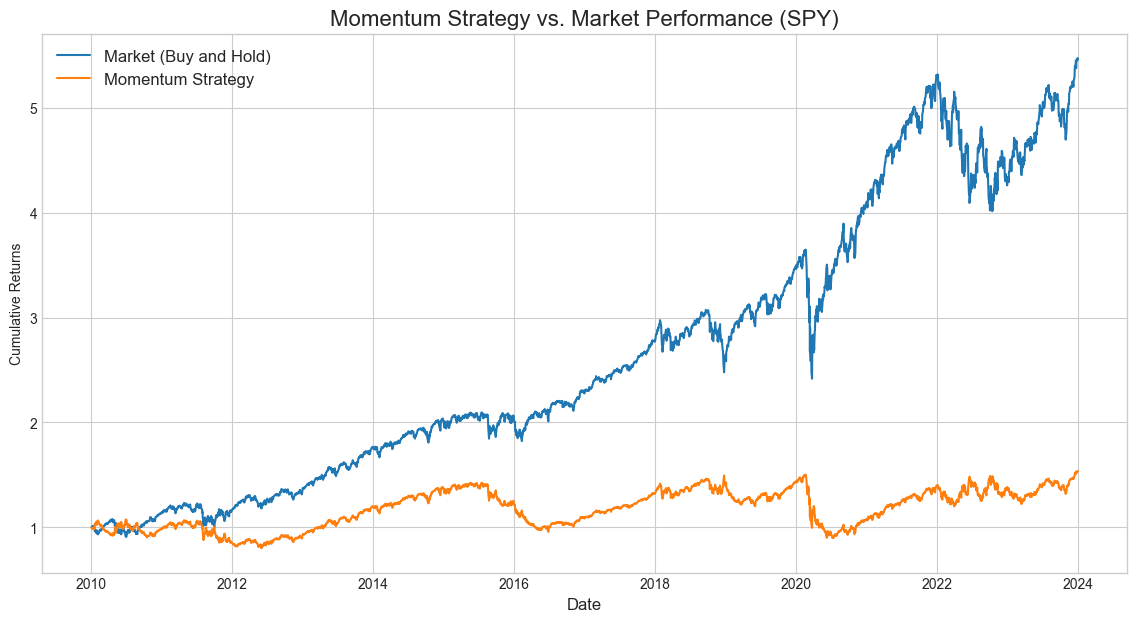

In [4]:
# Set the plot style for better readability and size
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(14, 7))

# Plot the cumulative returns of our strategy vs. the market
plt.plot(df['CumulativeMarketReturn'], label='Market (Buy and Hold)')
plt.plot(df['CumulativeStrategyReturn'], label='Momentum Strategy')

# Add titles and labels for clarity
plt.title('Momentum Strategy vs. Market Performance (SPY)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Returns')
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

In [5]:
# --- CALCULATIONS ---
# Drop missing values to ensure calculations are accurate
daily_strategy_returns = df['StrategyReturn'].dropna()

# Calculate total number of trading days in the period
days = (df.index[-1] - df.index[0]).days

# Calculate Compound Annual Growth Rate (CAGR)
cagr = (df['CumulativeStrategyReturn'].iloc[-1])**(365.0/days) - 1

# Calculate Annualized Volatility
annualized_volatility = daily_strategy_returns.std() * np.sqrt(252)

# Calculate Annualized Sharpe Ratio (assuming risk-free rate is 0)
sharpe_ratio = cagr / annualized_volatility

# Calculate Maximum Drawdown
cumulative_returns = (1 + daily_strategy_returns).cumprod()
running_max = cumulative_returns.expanding().max()
drawdown = (cumulative_returns - running_max) / running_max
max_drawdown = drawdown.min()


# --- PRINT RESULTS ---
print("--- Quant Trader's Performance Scorecard ---")
print(f"Strategy Timeframe: {df.index[0].date()} to {df.index[-1].date()}")
print(f"Compound Annual Growth Rate (CAGR): {cagr:.2%}")
print(f"Annualized Volatility: {annualized_volatility:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")

--- Quant Trader's Performance Scorecard ---
Strategy Timeframe: 2010-01-04 to 2023-12-29
Compound Annual Growth Rate (CAGR): 3.10%
Annualized Volatility: 17.35%
Sharpe Ratio: 0.18
Maximum Drawdown: -40.12%
